# Проект: Статистический анализ данных #

Аналитика популярного сервиса аренды самокатов GoFast. Имеем данные о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1. без подписки
* абонентская плата отсутствует;
* стоимость одной минуты поездки — 8 рублей;
* стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra
* абонентская плата — 199 рублей в месяц;
* стоимость одной минуты поездки — 6 рублей;
* стоимость старта — бесплатно.

Описание данных:
1. `users_go.csv`
    * `user_id` - уникальный идентификатор пользователя
    * `name` - имя пользователя
    * `age` - возраст
    * `city` - город
    * `subscription_type` - тип подписки (free, ultra)
2. `rides_go.csv`
    * `user_id` - уникальный идентификатор пользователя
    * `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
    * `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    * `date` - дата совершения поездки
3. `subscriptions_go.csv`
    * `subscription_type` - тип подписки
    * `minute_price` - стоимость одной минуты поездки по данной подписке
    * `start_ride_price` - стоимость начала поездки
    * `subscription_fee` - стоимость ежемесячного платежа

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from math import factorial

#### Шаг 1. Загрузка данных

In [2]:
try:
    users_df = pd.read_csv('users_go.csv')
except:
    users_df = pd.read_csv('****')

In [3]:
try:
    rides_df = pd.read_csv('rides_go.csv')
except:
    rides_df = pd.read_csv('****')

In [4]:
try:
    subscriptions_df = pd.read_csv('subscriptions_go.csv')
except:
    subscriptions_df = pd.read_csv('****')

Просмотрим каждый из датафреймов

In [5]:
users_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [6]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [7]:
rides_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [8]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [9]:
subscriptions_df.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
subscriptions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод** Успешно загружены 3 датафрейма
* users_df - содержит инфрмацию о пользователях: имя, возраст, город и тип подписки
* rides_df - содержит информацию о поездках польщзователей: id пользователя, расстояние, продолжительность поездки и дату
* subscriptions_df - содержит тарифную информацию о подписах: ежемесячную плату, стоиость  старта и стоимость минуты поездки

#### Шаг 2. Предобработка данных

Проверим датафреймы на наличие пропущенных значений

In [11]:
users_df.isna().mean()

user_id              0.0
name                 0.0
age                  0.0
city                 0.0
subscription_type    0.0
dtype: float64

In [12]:
rides_df.isna().mean()

user_id     0.0
distance    0.0
duration    0.0
date        0.0
dtype: float64

In [13]:
subscriptions_df.isna().mean()

subscription_type    0.0
minute_price         0.0
start_ride_price     0.0
subscription_fee     0.0
dtype: float64

Видим, что пропущенные знаения в датафреймах отсутствуют

В датафрейме `rides_df` столбец `date` приветем к типу `date` и создадим новый столбец `month` с номером месяца

In [14]:
# 2021-01-01
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y-%m-%d')

In [15]:
rides_df['month'] = rides_df['date'].dt.month

In [16]:
rides_df.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [17]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


Проверим датафреймы на дубликаты

Если в датафрейме `users_df` мы найдём записи с одинаковыми значениями имени, возраста и города, мы не можем говорить, что это  дубликаты. Это могут быть разные люди с одними данными, поэтому скрытые дубликаты не ищем. Найдём явные дубликаты

In [18]:
users_df.duplicated().sum()

31

Найдена 31 повторяющаяся запись. Удалим их

In [19]:
users_df = users_df.drop_duplicates(keep='first')
users_df = users_df.reset_index(drop=True)

In [20]:
users_df.duplicated().sum()

0

Найдём дубликаты в датафрейме `rides_df`

In [21]:
rides_df.duplicated().sum()

0

In [22]:
rides_df['distance'].value_counts()

741.545359     1
4158.226381    1
3672.118870    1
4533.004089    1
2437.274120    1
              ..
2949.530545    1
3289.893471    1
3047.554085    1
2931.718067    1
4031.935032    1
Name: distance, Length: 18068, dtype: int64

В датафрейме `rides_df` дубликаты отсутствуют.

В датафреёме `subscriptions_df` дубликаты отсутствуют по определению - там всего 2 записи

**Выводы.** В датафреймах пропущенные знаения  отсутствуют. В датафрейме `rides_df` столбец `date` привели к типу `date` и создадили новый столбец `month` с номером месяца. В датафрейме `users_df` удалили повторяющиеся записи, в остальных датафреймах дубликаты отсутствуют

#### Шаг 3. Исследовательский анализ данных

**Опишем и визуализируем частоту встречаемости городов**

In [23]:
user_city_pivot = users_df['city'].value_counts()
user_city_pivot

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

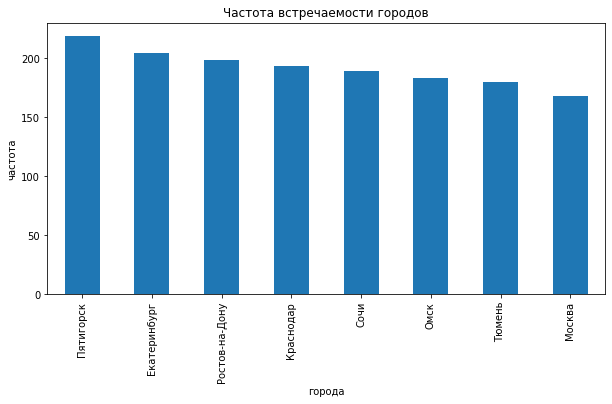

In [24]:
user_city_pivot.plot.bar(figsize=(10,5))
plt.title('Частота встречаемости городов')
plt.xlabel('города')
plt.ylabel('частота')
plt.show()

**Вывод** Больше всего пользователей в Пятигорске, Екатеринбурге и Ростове-на-Дону. Меньше - в Москве, Тюмени и Омске

**Опишем и визуализируем соотношение пользователей с подпиской и без подписки**

In [25]:
user_plan_pivot = users_df['subscription_type'].value_counts() / len(users_df) * 100
user_plan_pivot

free     54.432855
ultra    45.567145
Name: subscription_type, dtype: float64

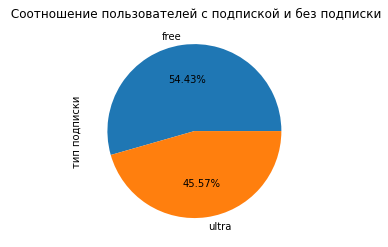

In [26]:
user_plan_pivot.plot.pie(autopct='%1.2f%%')
plt.title(' Соотношение пользователей с подпиской и без подписки')
plt.ylabel('тип подписки')
plt.show()

**Вывод** Видим, что пользователей с бесплатной подпиской немного больше.Их примерно 55%

**Опишем и визуализируем возраст пользователей**

In [27]:
user_age_pivot = users_df.pivot_table(index='age', values='user_id', aggfunc='count')
user_age_pivot

,user_id
age,
12,4
13,8
14,9
15,13
16,19
17,26
18,46
19,47
20,71


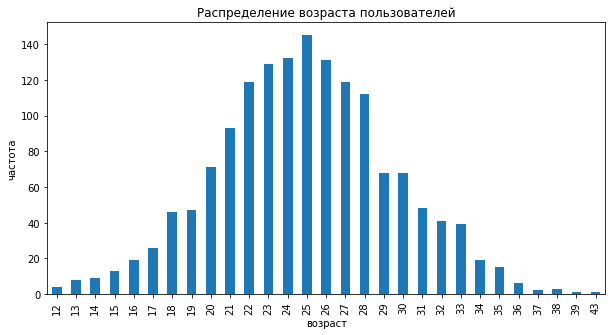

In [28]:
user_age_pivot.plot.bar(figsize=(10,5), legend=False);
plt.title('Распределение возраста пользователей')
plt.xlabel('возраст')
plt.ylabel('частота')
plt.show()

In [29]:
users_df['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**Вывод** И средний, и медианный возраст пользователей - 25 лет. По графику видим, что мода так же равна - 25

**Опишем и визуализируем расстояние поездки**

In [30]:
rides_df['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

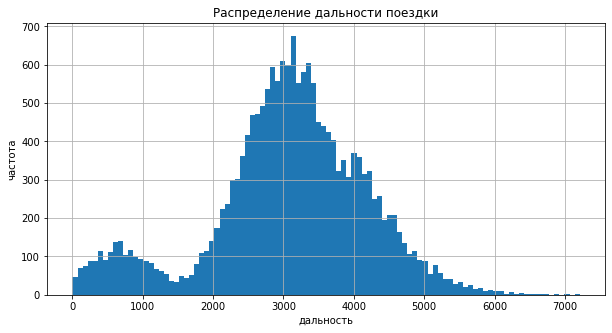

In [31]:
rides_df['distance'].hist(bins=100, figsize=(10,5));
plt.title('Распределение дальности поездки')
plt.xlabel('дальность')
plt.ylabel('частота')
plt.show()

**Вывод** Среднее и медианное значение расстояния одной поездки ~3100м

Дополнительно рассмотрим пик слева на промежутке  0-1500м

Сначала добавим столбец скорость `speed`

In [32]:
rides_df['speed'] = (rides_df['distance'] / rides_df['duration']) * (60 / 1000)

Возьмём выборку поезок менее 1500м

In [33]:
near_distance_df = rides_df[rides_df['distance'] < 1500]
near_distance_df

,user_id,distance,duration,date,month,speed
2,1,754.159807,6.232113,2021-04-20,4,7.260713
9,1,748.690645,15.041884,2021-11-22,11,2.986424
20,2,923.007439,6.914760,2021-08-03,8,8.009019
47,4,724.559572,11.811399,2021-11-14,11,3.680646
91,9,979.657684,17.521497,2021-03-08,3,3.354705
...,...,...,...,...,...,...
18031,1532,303.787850,7.792490,2021-05-21,5,2.339082
18037,1532,662.468186,9.528773,2021-11-18,11,4.171376
18043,1533,310.488247,10.642389,2021-02-21,2,1.750480
18049,1533,1034.998188,6.299996,2021-06-23,6,9.857132


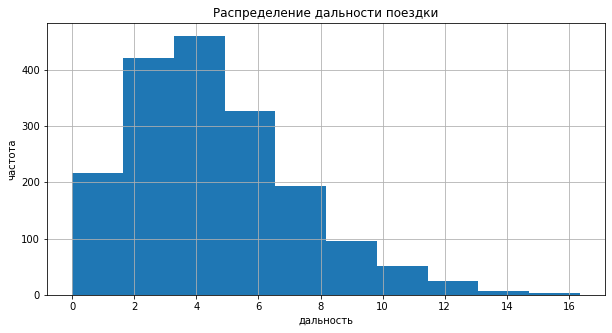

In [34]:
near_distance_df['speed'].hist(bins=10, figsize=(10,5));
plt.title('Распределение дальности поездки')
plt.xlabel('дальность')
plt.ylabel('частота')
plt.show()

Опишем данные скорости для коротких поездок и для всего датафрейма

In [35]:
near_distance_df['speed'].describe()

count    1796.000000
mean        4.569765
std         2.681076
min         0.005133
25%         2.635567
50%         4.180627
75%         6.117972
max        16.351400
Name: speed, dtype: float64

In [36]:
rides_df['speed'].describe()

count    18068.000000
mean        13.785261
std         44.156189
min          0.005133
25%          8.127843
50%         10.251135
75%         12.929800
max        865.320929
Name: speed, dtype: float64

Удалим столбец `speed`. Он больше не понадобится

In [37]:
rides_df.drop('speed', axis=1)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11
18064,1534,2840.423057,21.409799,2021-11-16,11
18065,1534,3826.185507,18.435051,2021-11-18,11
18066,1534,2902.308661,16.674362,2021-11-27,11


**Вывод** При детальном рассмотрении пика на 800м увидели, что средняя скорость таких поездок около 4.5км/ч, медианная - 4.1км/ч, что медленней скорости пешехода. На всём датафрейме средняя скорость - 13км/ч. Вероятно такая дальность поездок связана с неисправностью самокатов. **Необходимо дополнительное исследование**

**Опишем и визуализируем продолжительность поездки**

In [38]:
rides_df['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

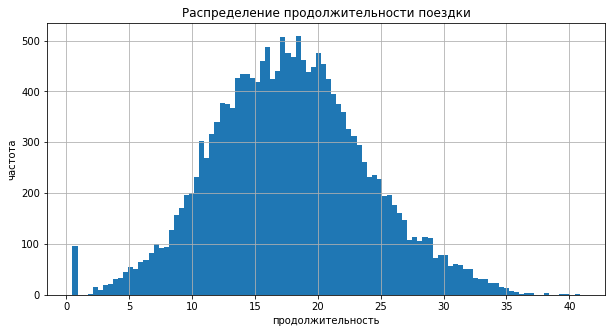

In [39]:
rides_df['duration'].hist(bins=100, figsize=(10,5));
plt.title('Распределение продолжительности поездки')
plt.xlabel('продолжительность')
plt.ylabel('частота')
plt.show()

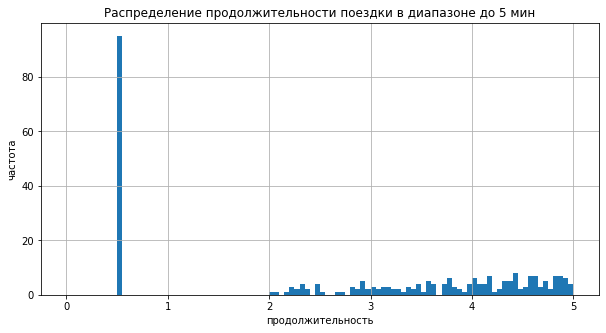

In [40]:
rides_df['duration'].hist(bins=100, range=(0,5), figsize=(10,5));
plt.title('Распределение продолжительности поездки в диапазоне до 5 мин')
plt.xlabel('продолжительность')
plt.ylabel('частота')
plt.show()

Видим аномальный выброс значений менее 1мин. Удалим его

In [41]:
rides_df[rides_df['duration'] < 1]

,user_id,distance,duration,date,month,speed
6531,701,4196.445201,0.5,2021-08-31,8,503.573424
6570,704,4830.824371,0.5,2021-10-14,10,579.698925
6680,712,4684.004397,0.5,2021-03-04,3,562.080528
6695,713,5215.642710,0.5,2021-02-25,2,625.877125
6768,718,5197.436649,0.5,2021-02-11,2,623.692398
...,...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1,663.760301
17242,1477,6724.932981,0.5,2021-01-12,1,806.991958
17314,1483,4445.481070,0.5,2021-03-06,3,533.457728
17505,1496,5722.551787,0.5,2021-02-14,2,686.706214


In [42]:
rides_df = rides_df[rides_df['duration'] > 1]

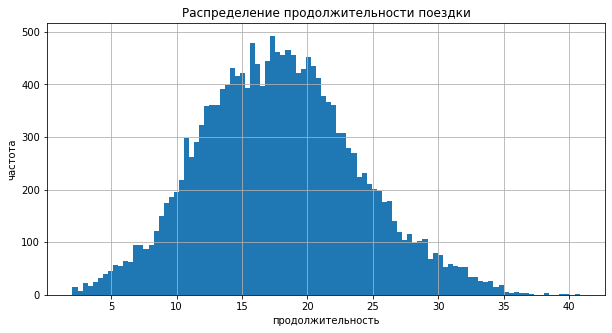

In [43]:
rides_df['duration'].hist(bins=100, figsize=(10,5));
plt.title('Распределение продолжительности поездки')
plt.xlabel('продолжительность')
plt.ylabel('частота')
plt.show()

In [44]:
rides_df['duration'].describe()

count    17973.000000
mean        17.896480
std          5.975424
min          2.035632
25%         13.670439
50%         17.714122
75%         21.747016
max         40.823963
Name: duration, dtype: float64

**Вывод** Средняя продолжительность поездки 17.9мин, медианное значение - 17.7мин. На этом этапе удалены записи с аномальными значениями. 

**Выводы**
* Больше всего пользователей в Пятигорске, Екатеринбурге и Ростове-на-Дону. Меньше - в Москве, Тюмени и Омске
* пользователей с бесплатной подпиской немного больше.Их примерно 54.5% Платную подписку имеют 45.4% пользователей
* Средний и медианный возраст пользователей - 25 лет
* Среднее и медианное значение расстояния одной поездки ~3100м
* Средняя продолжительность поездки 17.9мин, медианное значение - 17.7мин. 
* На этом этапе удалены записи с аномальными значениями

#### Шаг 4. Объединение данных

 Объединим данные о пользователях, поездках и подписках в один датафрейм.

In [45]:
merge_df = rides_df.merge(users_df, on='user_id')

In [46]:
merge_df = merge_df.merge(subscriptions_df, on='subscription_type')

Изучим полученный датафрейм

In [47]:
merge_df.head()

,user_id,distance,duration,date,month,speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,10.335841,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,9.929620,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,7.260713,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,8.734644,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,9.202888,Кира,22,Тюмень,ultra,6,0,199


In [48]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 18067
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   17973 non-null  int64         
 1   distance  17973 non-null  float64       
 2   duration  17973 non-null  float64       
 3   date      17973 non-null  datetime64[ns]
 4   month     17973 non-null  int64         
 5   speed     17973 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 982.9 KB


In [49]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17973 entries, 0 to 17972
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   distance           17973 non-null  float64       
 2   duration           17973 non-null  float64       
 3   date               17973 non-null  datetime64[ns]
 4   month              17973 non-null  int64         
 5   speed              17973 non-null  float64       
 6   name               17973 non-null  object        
 7   age                17973 non-null  int64         
 8   city               17973 non-null  object        
 9   subscription_type  17973 non-null  object        
 10  minute_price       17973 non-null  int64         
 11  start_ride_price   17973 non-null  int64         
 12  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(3)
memory 

Длины начального датафрейма с поездками `rides_df` и нового датафрейма `merge_df` не отличаются. Склейка прошла успешно.

Создадим отдельные датафреймы c данными о пользователях без подписки и с подпиской

In [50]:
ultra_plan_users_df = merge_df[merge_df['subscription_type'] == 'ultra']

In [51]:
free_plan_users_df = merge_df[merge_df['subscription_type'] == 'free']

Выведем первые строки полученных датафреймов

In [52]:
ultra_plan_users_df.head()

,user_id,distance,duration,date,month,speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,10.335841,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,9.929620,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,7.260713,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,8.734644,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,9.202888,Кира,22,Тюмень,ultra,6,0,199


In [53]:
free_plan_users_df.head()

,user_id,distance,duration,date,month,speed,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,10.100278,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,3.130090,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,12.003323,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,7.396057,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,10.491519,Айдар,22,Омск,free,8,50,0


Визуализируем информацию о расстоянии и времени поездок для пользователей с подпиской.

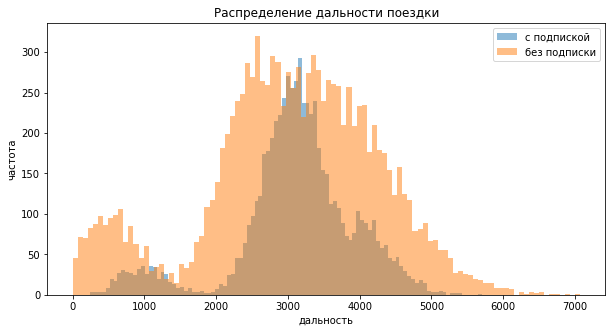

In [54]:
ultra_plan_users_df['distance'].plot(kind='hist', bins=100, figsize=(10,5), label='с подпиской', alpha=0.5, legend=True);
free_plan_users_df['distance'].plot(kind='hist', bins=100, figsize=(10,5), label='без подписки', alpha=0.5, legend=True);
plt.title('Распределение дальности поездки')
plt.xlabel('дальность')
plt.ylabel('частота')
plt.show()

In [55]:
ultra_distance_describe = ultra_plan_users_df['distance'].describe()
free_distance_describe = free_plan_users_df['distance'].describe()
distance_describe = pd.concat([ultra_distance_describe, free_distance_describe], axis=1)
distance_describe.columns = ['ultra', 'free']
distance_describe

,ultra,free
count,6500.000000,11473.000000
mean,3115.445388,3028.374239
std,836.895330,1235.541051
min,244.210438,0.855683
25%,2785.444017,2360.878149
50%,3148.637229,3102.083025
75%,3560.574425,3883.979311
max,5699.769662,7066.003772


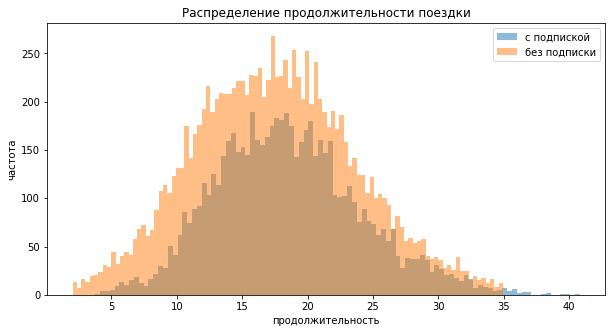

In [56]:
ultra_plan_users_df['duration'].plot(kind='hist', bins=100, figsize=(10,5), label='с подпиской', alpha=0.5, legend=True);
free_plan_users_df['duration'].plot(kind='hist', bins=100, figsize=(10,5), label='без подписки', alpha=0.5, legend=True);
plt.title('Распределение продолжительности поездки')
plt.xlabel('продолжительность')
plt.ylabel('частота')
plt.show()

In [57]:
ultra_duration_describe = ultra_plan_users_df['duration'].describe()
free_duration_describe = free_plan_users_df['duration'].describe()
duration_describe = pd.concat([ultra_duration_describe, free_duration_describe], axis=1)
duration_describe.columns = ['ultra', 'free']
duration_describe

,ultra,free
count,6500.000000,11473.000000
mean,18.541985,17.530771
std,5.572048,6.162609
min,3.760353,2.035632
25%,14.524654,13.085688
50%,18.178153,17.383807
75%,21.884129,21.638038
max,40.823963,34.948498


**Вывод** На этом этапе объединили данные о пользователях, поездках и подписках в один датафрейм, а потом на основе полученного датафрейм создали еще 2 с данными о пользователях с подпиской и без подписки

По графикам и таблицам видно, что распределение продолжительности поездки для пользователей с подпиской и без подписки отличаются не сильно, но в целом продолжительность поездок у пользователей с подпиской больше
* Медианное значение для пользователей с подпиской - 18.2мин, среднее - 18.5мин
* Медианное значение для пользователей без подписки - 17.4 мин, среднее - 17.5 мин

Графики распределения дальности поездок отличаются сильнее. Средние величины похожи, но у графика дальности поездок у пользователей без подписки купл значительно шире - стандартное отклонение больше
* Медианное значение для пользователей с подпиской - 3148м, среднее - 3115м
* Медианное значение для пользователей без подписки - 3102м, среднее - 3028м

#### Шаг 5. Подсчёт выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [58]:
merge_df['duration'] = np.ceil(merge_df['duration']) 
merge_df['distance'] = merge_df['distance'].round(2)

In [59]:
user_pivot = merge_df.pivot_table(index=['user_id', 'month'], values=['distance', 'duration'], aggfunc=['sum', 'count'])
user_pivot.columns = ['distance', 'duration','count', 'count1']
del user_pivot['count1']
user_pivot

distance  duration  count
user_id month                           
1       1       7027.51      42.0      2
        4        754.16       7.0      1
        8       6723.47      46.0      2
        10      5809.91      32.0      2
        11      7003.50      56.0      3
...                 ...       ...    ...
1534    6       3409.47      26.0      2
        8       7622.45      48.0      2
        9       4928.17      23.0      1
        11     13350.02      78.0      4
        12      2371.71      16.0      1

[11300 rows x 3 columns]

Добавим в эту сводную таблицу данные о тарифе пользователя

In [60]:
user_plan_pivot = merge_df.pivot_table(index=['user_id', 'month'], values = ['minute_price','start_ride_price','subscription_fee'])
user_plan_pivot

minute_price  start_ride_price  subscription_fee
user_id month                                                  
1       1                 6                 0               199
        4                 6                 0               199
        8                 6                 0               199
        10                6                 0               199
        11                6                 0               199
...                     ...               ...               ...
1534    6                 8                50                 0
        8                 8                50                 0
        9                 8                50                 0
        11                8                50                 0
        12                8                50                 0

[11300 rows x 3 columns]

In [61]:
user_pivot = user_pivot.merge(user_plan_pivot, on=['user_id', 'month'])
user_pivot

distance  duration  count  minute_price  start_ride_price  \
user_id month                                                              
1       1       7027.51      42.0      2             6                 0   
        4        754.16       7.0      1             6                 0   
        8       6723.47      46.0      2             6                 0   
        10      5809.91      32.0      2             6                 0   
        11      7003.50      56.0      3             6                 0   
...                 ...       ...    ...           ...               ...   
1534    6       3409.47      26.0      2             8                50   
        8       7622.45      48.0      2             8                50   
        9       4928.17      23.0      1             8                50   
        11     13350.02      78.0      4             8                50   
        12      2371.71      16.0      1             8                50   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199  
...                         ...  
1534    6                     0  
        8                     0  
        9                     0  
        11                    0  
        12                    0  

[11300 rows x 6 columns]

Так же добавим в таблицу столбец с помесячной выручкой для каждого пользователя. Для этого сначала определим функцию

In [62]:
def calc_revenue(row):
    return row['subscription_fee'] + (row['start_ride_price'] * row['count']) + (row['duration'] * row['minute_price'])

In [63]:
user_pivot['monthly_revenue'] = user_pivot.apply(calc_revenue, axis=1)
user_pivot

distance  duration  count  minute_price  start_ride_price  \
user_id month                                                              
1       1       7027.51      42.0      2             6                 0   
        4        754.16       7.0      1             6                 0   
        8       6723.47      46.0      2             6                 0   
        10      5809.91      32.0      2             6                 0   
        11      7003.50      56.0      3             6                 0   
...                 ...       ...    ...           ...               ...   
1534    6       3409.47      26.0      2             8                50   
        8       7622.45      48.0      2             8                50   
        9       4928.17      23.0      1             8                50   
        11     13350.02      78.0      4             8                50   
        12      2371.71      16.0      1             8                50   

               subscription_fee  monthly_revenue  
user_id month                                     
1       1                   199            451.0  
        4                   199            241.0  
        8                   199            475.0  
        10                  199            391.0  
        11                  199            535.0  
...                         ...              ...  
1534    6                     0            308.0  
        8                     0            484.0  
        9                     0            234.0  
        11                    0            824.0  
        12                    0            178.0  

[11300 rows x 7 columns]

**Вывод** Создали сводный атафрейм с агрегированными данными о поездках: количестве, продолжительности и расстоянии за месяц. Так же в эту таблицу добавили столбец с помесячной выручкой, которую принёс каждый пользователь.

#### Шаг 6. Проверка гипотез

**Продолжительность поездок**

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании
* Нулевая гипотеза: продолжительности поездок у пользователей с подпиской и без подписки равны. H0: $\mu$1 = $\mu$2
* Альтенативная гипотеза: продолжительность поездок у пользователей с подпиской выше, чем у пользователй без подписки. H1: $\mu$1 > $\mu$2

In [64]:
alpha = 0.05
results = st.ttest_ind(ultra_plan_users_df['duration'], free_plan_users_df['duration'], alternative='greater')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 4.704468074453899e-28
Отвергаем нулевую гипотезу


**Вывод** Отвергаем нулевую гипотезу. Это значит, что **продолжительность поездок пользователей с подпиской и без подписки не равны**

**Расстояние одной поездки**

Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

* Нулевая гипотеза: расстояние одной поездки равно 3130м. H0: $\mu$ = 3130
* Альтенативная гипотеза: расстояние одной поездки меньше 3130м. H1: $\mu$ > 3130

In [65]:
alpha = 0.05
ref_value = 3130

results = st.ttest_1samp(ultra_plan_users_df['distance'], ref_value, alternative='greater')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


**Вывод** Оснований отвергать  нулевую теорию нет, т.к. полученное значение выше заданного уровня значимости. Это значит можно сказать, что **среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров**

**Помесячная выручка от пользователей**

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

* Нулевая гипотеза: помесячная выручка у пользователей с подпиской и без подписки равны. H0: $\mu$1 = $\mu$2
* Альтенативная гипотеза: помесячная выручка у пользователей с подпиской выше, чем у пользователй без подписки. H1: $\mu$1 > $\mu$2

In [66]:
# user_pivot
alpha = 0.05
results = st.ttest_ind(
    user_pivot[user_pivot['subscription_fee'] != 0]['monthly_revenue'], 
    user_pivot[user_pivot['subscription_fee'] == 0]['monthly_revenue'], 
    alternative='greater'
)
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 2.0314113674863288e-30
Отвергаем нулевую гипотезу


**Вывод** Отвергаем нулевую гипотезу. Это значит, что **помесячная выручка от пользователей с подпиской выше,  чем от пользователей без  подписки**

**Обновление сервера**

Техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Есть файл , содержащий для каждого пользователя данные о количестве обращений до обновления и после него. 

Для провери этой гипотезы нам нужно провести тест о равенстве средних для зависимых (парных) выборок
* Нулевая гипотеза: количество обращений не изменилось H0: $\mu$1 = $\mu$2
* Альтенативная гипотеза: количество обращений после обновления снизилось H1: $\mu$1 > $\mu$2

`results = st.ttest_rel(before, after, aternative='greater')`

**Вывод** Проверили ряд гипотез со следующими выводами:
* продолжительность поездок пользователей с подпиской и без подписки не равны
* среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
* помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки

### Общий вывод 

Были загружены 3 датафрейма с информацией о пользователях, их поездках и информацией о тарифных планах сервиса. Произведена предварительная обработка даных: в датафрейме `rides_df` столбец `date` привели к типу `date` и создадили новый столбец `month` с номером месяца. В датафрейме `users_df` удалили повторяющиеся записи, в остальных датафреймах дубликаты отсутствуют. В датафреймах пропущенные знаения отсутствуют. Удалены значения с аномальными значениями.

Проведён исследовательский анализ данных со следующими выводами:
* Больше всего пользователей в Пятигорске, Екатеринбурге и Ростове-на-Дону. Меньше - в Москве, Тюмени и Омске
* Пользователей с бесплатной подпиской немного больше.Их примерно 54.5% Платную подписку имеют 45.4% пользователей
* Средний и медианный возраст пользователей - 25 лет
* Среднее и медианное значение расстояния одной поездки ~3100м
* Средняя продолжительность поездки 17.9мин, медианное значение - 17.7мин.

Объединили данные о пользователях, поездках и подписках в один датафрейм, а потом на основе полученного датафрейм создали еще 2 с данными о пользователях с подпиской и без подписки. На основе этих таблиц создали сводный датафрейм с агрегированными данными о поездках: количестве, продолжительности и расстоянии за месяц. Так же в эту таблицу добавили столбец с помесячной выручкой, которую принёс каждый пользователь.
* Медианное значение продолжительности поездки для пользователей с подпиской - 18.2мин, среднее - 18.5мин
* Медианное значение продолжительности поездки для пользователей без подписки - 17.4 мин, среднее - 17.5 мин
* Медианное значение расстояния поездки для пользователей с подпиской - 3148м, среднее - 3115м
* Медианное значение расстояния поездки для пользователей без подписки - 3102м, среднее - 3028м

Проверили ряд гипотез со следующими выводами:
* пользователи с подпиской тратят больше времени на поездки
* среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
* помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки